In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def label_to_dict(labels):

    return {label: index for index, label in enumerate(labels)}

def compute_pt_eta_phi(px,py,pz):

    pt = np.sqrt(px**2 + py**2)
    eta = np.arctanh(pz/np.sqrt(pt**2+pz**2))
    phi = np.arctan2(py, px)
    phi = np.where(phi < 0., phi + 2 * np.pi, phi)
    phi = np.where(phi >= 2.*np.pi, phi - 2 * np.pi, phi)

    return pt, eta, phi

def apply_lognorm(image, vmin, vmax):
    # Apply the log transformation
    log_image = np.log(np.clip(image, vmin, vmax))
    # Normalize to [0, 1] range
    log_image_normalized = (log_image - np.log(vmin)) / (np.log(vmax) - np.log(vmin))
    return log_image_normalized

In [3]:
class DataLoader:
    def __init__(self, clean_data_path, noisy_data_path, constituent_labels, jet_obs_labels, image_shape=(32,32,3)):
    
        self.clean_data_path = clean_data_path
        self.noisy_data_path = noisy_data_path
        self.const_dict = label_to_dict(constituent_labels)
        self.jet_obs_dict = label_to_dict(jet_obs_labels)
        self.image_shape = image_shape

    # def delta_phi(self, event_const, event_jet):

    #     px = event_const[:,self.const_dict['jPx']]
    #     py = event_const[:,self.const_dict['jPy']]
    #     pz = event_const[:,self.const_dict['jPz']]

    #     pt, eta, phi = compute_pt_eta_phi(px,py,pz)
    #     jet_phi = event_jet[:,self.jet_obs_dict['phiJet']]
    #     dphi = phi-jet_phi
    #     dphi = np.where(dphi<-np.pi, dphi+2*np.pi, dphi)
    #     dphi = np.where(dphi>np.pi, dphi-2*np.pi, dphi)
    #     return dphi

    def read_data_file(self, data_path, delimiter=','):

        # define a dictionary to store constituent and jet information
        data = {'const': {}, 'jet': {}}

        const_data_length = len(self.const_dict)
        jet_data_length = len(self.jet_obs_dict)

        event_index=0

        with open(data_path, 'r') as file:

            for line in file:
                # skip comment rows that start with a '#'
                if line[0]=='#':
                    continue

                # split the line by the delimiter
                # since we need to save them in the same numpy array, cast them all as floats (though some are ints)
                split_line = [float(element) for element in line.strip().split(delimiter)]
                # first element of the line is the event index which we use as a key; everything else are values
                event = event_index
                event_data = np.expand_dims( np.asarray(split_line[1:]), axis=0 )

                if event_data.shape[1]==const_data_length:

                    # check if this key already exists. If so, stack the new particle on top of what is already there; if not, add it
                    if data['const'].get(event) is not None:
                        if len(data['const'][event])==0: # empty event
                            continue
                        data['const'][event] = np.vstack((data['const'][event], event_data))
                    else:
                        data['const'][event] = event_data


                elif event_data.shape[1]==jet_data_length:
                    # if all of the elements after 0 are -1, this is code for an empty event with no constituents
                    if np.all(event_data==-1):
                        event_index = event_index+1
                        continue
                
                    data['jet'][event] = event_data
                    # increment the event index, since this happens exactly once per event
                    event_index = event_index+1

        return data
    
    def load_data(self):

        return self.read_data_file(self.clean_data_path), self.read_data_file(self.noisy_data_path)

    def extract_numerical_data(self, dataset, data_type, variable_name):

        if data_type=='const':
            index = self.const_dict[variable_name]
            # remove cases where constituent array has length 0 (missing events)
            obs_data = np.concatenate([arr[:, index] for arr in dataset[data_type].values() if arr.shape[0] > 0])

        elif data_type=='jet':
            index = self.jet_obs_dict[variable_name]
            # remove all "-1" elements (missing events)
            obs_data = np.concatenate([arr[:, index] for arr in dataset[data_type].values() if np.all(arr!=-1)])
        else:
            print('Type must be const or jet')

        return obs_data
    
    def make_image(self, event_const, event_jet):

        px = event_const[:,self.const_dict['jPx']]
        py = event_const[:,self.const_dict['jPy']]
        pz = event_const[:,self.const_dict['jPz']]
        pt, eta, phi = compute_pt_eta_phi(px,py,pz)

        jet_pt = event_jet[:,self.jet_obs_dict['pTJet']]
        jet_eta = event_jet[:,self.jet_obs_dict['etaJet']]
        jet_phi = event_jet[:,self.jet_obs_dict['phiJet']]
        if (jet_phi<0):
            jet_phi += 2.*np.pi
        elif (jet_phi>=2.*np.pi):
            jet_phi -= 2.*np.pi
        pt_weight = pt/jet_pt

        # event_img,_,_ = np.histogram2d( eta, phi, weights=pt_weight, bins=[np.linspace(-5,5,self.image_shape[0]+1),np.linspace(-0.1,2.*np.pi+0.1,self.image_shape[1]+1)] )
        event_img,_,_ = np.histogram2d( eta-jet_eta, phi-jet_phi, weights=pt_weight, bins=[np.linspace(-0.4,0.4,self.image_shape[0]+1),np.linspace(-0.4,0.4,self.image_shape[1]+1)] )
        lognorm_img = apply_lognorm(event_img, 0.001, 1)

        return np.transpose(np.stack((lognorm_img, lognorm_img, lognorm_img)))
    
    def extract_image_data(self, dataset):

        return np.stack([self.make_image(dataset['const'][key], dataset['jet'][key]) for key in dataset['jet'].keys()])
    
    def plot_histograms(self, clean_dataset, noisy_dataset, data_type):

        if data_type=='const':
            type_dict = self.const_dict
        elif data_type=='jet':
            type_dict = self.jet_obs_dict
        else:
            print('Type must be const or jet')

        num_plots = len(type_dict)
        num_rows = int( np.ceil(num_plots/3) )
        figure_length = 2.5*num_rows

        fig, axes = plt.subplots(num_rows,3, figsize=(8,figure_length))
        axes = axes.flat
        for i, label in enumerate(list(type_dict.keys())):
            axes[i].hist(self.extract_numerical_data(clean_dataset, data_type, label), histtype='step', label='signal' )
            axes[i].hist(self.extract_numerical_data(noisy_dataset, data_type, label), histtype='step', label='signal+bkg' )
            axes[i].set_title(label)
            axes[i].legend()
    
        plt.tight_layout()
        plt.show()

    def show_images(self, clean_images, noisy_images, num_images):

        # randomly select num_images from the dataset
        image_indices = np.random.randint(0, len(clean_images), size=num_images)
        print(image_indices)

        num_rows = num_images
        figure_length = 2.5*num_rows

        fig, axes = plt.subplots(num_rows, 2, figsize=(6, figure_length))
        for i, image_index in enumerate(image_indices):
            axes[i,0].imshow(clean_images[image_index])
            axes[i,1].imshow(noisy_images[image_index])
            axes[i,0].set_title('signal')
            axes[i,1].set_title('signal+bkg')

        plt.tight_layout()
        plt.show()


def extract_matched_data(clean_dataset, noisy_dataset):

    matched_clean = {'const': {}, 'jet': {}}
    matched_noisy = {'const': {}, 'jet': {}}

    assert( clean_dataset['const'].keys()==clean_dataset['jet'].keys() )
    assert( noisy_dataset['const'].keys()==noisy_dataset['jet'].keys() )

    matched_events = clean_dataset['jet'].keys() & noisy_dataset['jet'].keys()

    for type_name in list(matched_clean.keys()):

        matched_clean[type_name] = {event: clean_dataset[type_name][event] for event in matched_events}
        matched_noisy[type_name] = {event: noisy_dataset[type_name][event] for event in matched_events}

    return matched_clean, matched_noisy      

In [4]:
clean_filename = '../datasets/Delphes_Pythia_bkg0_output_Sig.out'
noisy_filename = '../datasets/Delphes_Pythia_bkg1_output_Sig.out'
const_labels = ['jPID', 'jCharge', 'jPx', 'jPy', 'jPz']
jet_obs_labels = ['pTJet', 'etaJet', 'phiJet', 'mJet', 'nJet', 'zDyG', 'thDyG', 'ktDyG', 'ptSD', 'mSD', 'zSD', 'ptRSD', 'nRSD', 'tau1', 'tau2', 'tau3', 'tau4', 'tau5']


loader = DataLoader(clean_filename, noisy_filename, const_labels, jet_obs_labels)
clean_dataset, noisy_dataset = loader.load_data()

matched_clean, matched_noisy = extract_matched_data(clean_dataset, noisy_dataset)

In [5]:
clean_images = loader.extract_image_data(matched_clean)
noisy_images = loader.extract_image_data(matched_noisy)

[25854 17703 27043 27257 28611]


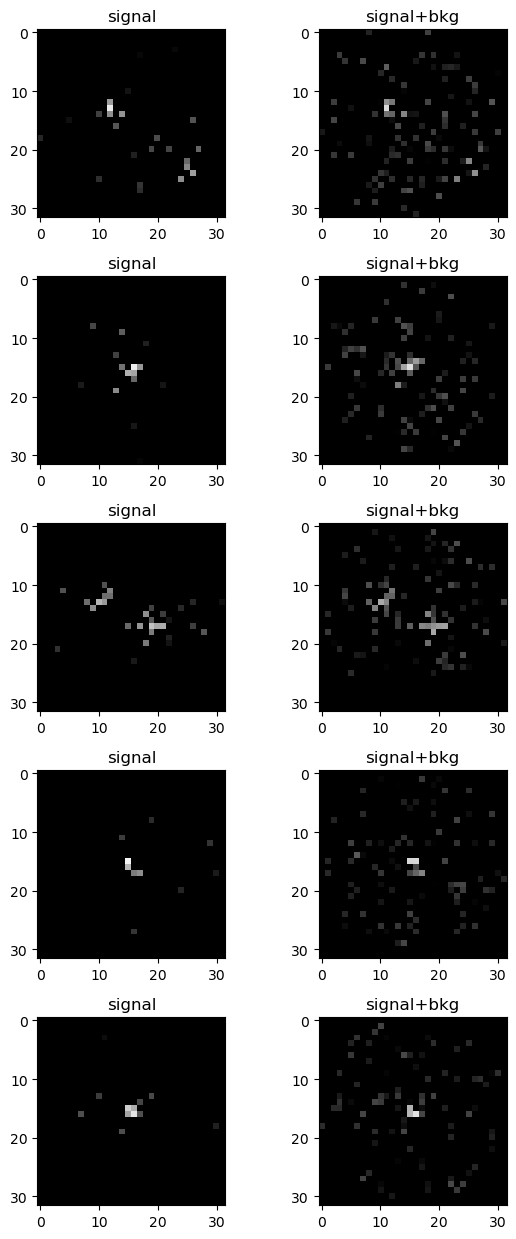

In [6]:
loader.show_images(clean_images, noisy_images, 5)

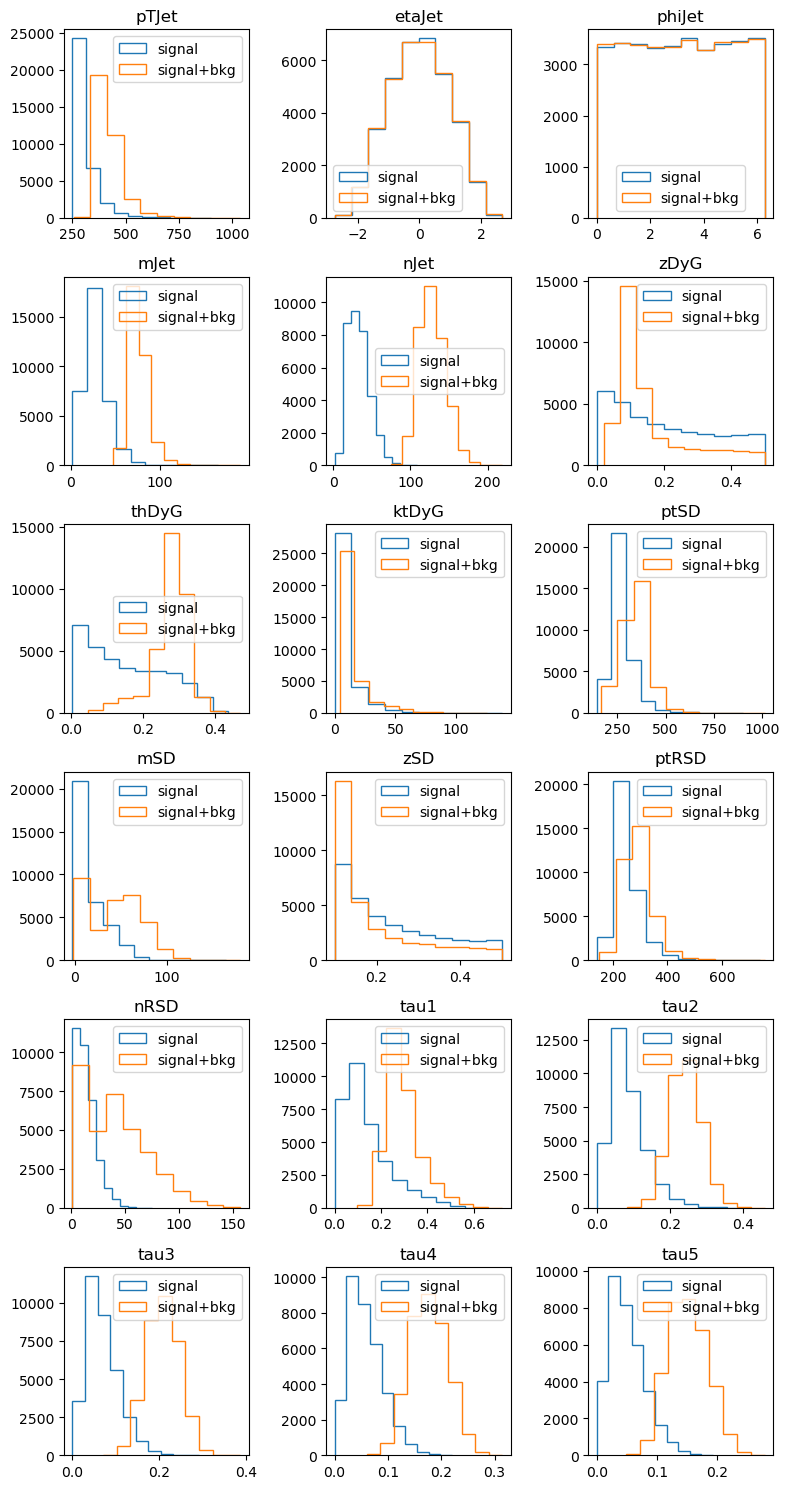

In [7]:
loader.plot_histograms(matched_clean, matched_noisy, 'jet')

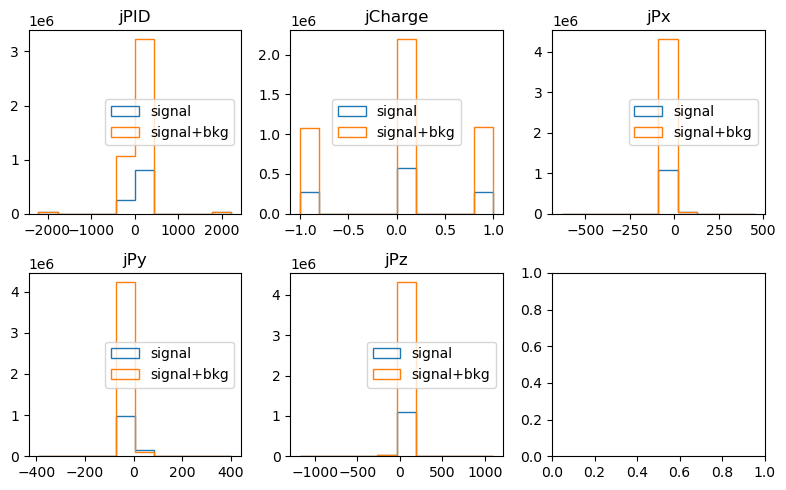

In [8]:
loader.plot_histograms(matched_clean, matched_noisy, 'const')